# Joggling Analysis
Scott Jenkins

- Create and test views / visualisations for joggling archive app
- Other analysis / questions


In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
from itertools import combinations
pd.options.display.max_rows = None

from pyvis.network import Network
import networkx as nx

import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [6]:
data = pd.read_csv('results.csv')
data.head()

,Date,Year,Distance,Standard Distance?,Event / Venue,Joggler,Gender,Nationality,Finish Time,Drops,Notes / Result Links,Unnamed: 11,Unnamed: 12
0,28/01/2024,2024,3b 6.7km,No,"The Snowy Soles Snowshoe Race, Ontario",Michal Kapral,M,CAN,00:49:24,?,https://www.instagram.com/p/C2pmYbarGbq/,NaN,NaN
1,27/01/2024,2024,3b 5km,Yes,Holyrood Parkrun,James McDiarmid,M,GBR,00:21:30,0,https://www.parkrun.org.uk/holyrood/results/73/,NaN,NaN
2,27/01/2024,2024,3b 5km,Yes,Młynówka Królewska Parkrun,Kacper Suchora,M,POL,00:23:45,?,https://www.parkrun.pl/mlynowkakrolewska/resul...,NaN,NaN
3,27/01/2024,2024,3b 5km,Yes,Holyrood Parkrun,Scott Jenkins,M,GBR,00:25:21,3,https://www.parkrun.org.uk/holyrood/results/73/,NaN,NaN
4,27/01/2024,2024,3b 5km,Yes,College of Micronesia-FSM Fun Run,Dana Lee Ling,M,FSM,00:38:11,?,https://www.strava.com/athletes/16093155?oq=dan,NaN,NaN


In [7]:
print(f'There are {len(data)} joggling results from {len(data['Joggler'].unique())} jogglers.')

countries = data[data['Nationality']!='0']['Nationality'].unique()
print(f'These Jogglers represent {len(countries)} countries: {countries}')

There are 1029 joggling results from 259 jogglers.
These Jogglers represent 23 countries: ['CAN' 'GBR' 'POL' 'FSM' 'USA' 'AUS' 'SWE' 'TUR' 'DEU' 'IRL' 'ISR' 'EST'
 'CZE' 'ITA' 'JPN' 'TWN' 'BEL' 'ZAF' 'AUT' 'IND' 'NLD' 'MEX' 'NOR']


## Jogglers Pivot

In [50]:
data = pd.read_csv('results.csv')    ## xlsx not supported.

# joggler_df = data[['Joggler','Nationality']].drop_duplicates().reset_index(drop=True).replace({'0':'Unknown'})

joggler_df = (data.groupby(['Joggler','Nationality','Gender'])
                  .agg({'Year':['min','max'],'Event / Venue':'count'})
                  .reset_index()
                  .replace({'0':'Unknown'})
)
joggler_df.columns = ['Joggler','Nationality','Gender','First Active','Last Active','Entry Count']
joggler_df['Years Active'] = 1 + joggler_df['Last Active'] - joggler_df['First Active']
joggler_df = joggler_df[['Joggler','Nationality','Gender','Years Active','First Active','Last Active','Entry Count']]

pivot_df = pd.pivot_table(data,
                          values='Finish Time',
                          index='Joggler', 
                          columns='Distance', 
                          aggfunc='min')
pivot_df = pivot_df[['3b Mile','3b 5km','3b 10km','3b Half Marathon','3b Marathon','5b Mile','5b 5km']].reset_index().fillna('-')

joggler_df = joggler_df.merge(pivot_df,on='Joggler')

joggler_df.head()

,Joggler,Nationality,Gender,Years Active,First Active,Last Active,Entry Count,3b Mile,3b 5km,3b 10km,3b Half Marathon,3b Marathon,5b Mile,5b 5km
0,Aaron Scott,USA,M,1,2020,2020,2,00:05:21,00:17:47,-,-,-,-,-
1,Adam Griffin,Unknown,M,1,1996,1996,1,00:06:07,-,-,-,-,-,-
2,Albert Lucas,USA,M,10,1987,1996,8,00:05:27,00:20:39,-,-,03:29:04,-,-
3,Andrea Goranson,Unknown,F,1,1992,1992,1,00:10:56,-,-,-,-,-,-
4,Andrew Head,Unknown,M,3,1983,1985,2,00:05:29,-,-,-,-,-,-


## Joggler Graph

### Prepare Data

In [71]:
# Get list of jogglers
jogglers = list(data['Joggler'].unique())
jogglers[:4]

['Michal Kapral', 'James McDiarmid', 'Kacper Suchora', 'Scott Jenkins']

In [72]:
# Group the data by date and event and list the jogglers participating
joggled_together = pd.DataFrame(data.groupby(['Date','Event / Venue'])['Joggler'].apply(lambda x: list(np.unique(x))).reset_index())
joggled_together = joggled_together[~joggled_together['Event / Venue'].isin(['Time Trial','IJA, Virtual'])].reset_index(drop=True)

# Count the number of jogglers at each event, and remove any events where the joggler has joggled alone
joggled_together['joggler_count'] = joggled_together['Joggler'].apply(lambda x: len(x))
joggled_together = joggled_together[joggled_together['joggler_count']>1].reset_index(drop=True)

joggled_together.head() # sort_values('joggler_count',ascending=False)

,Date,Event / Venue,Joggler,joggler_count
0,02/07/2022,Endure24 Leeds,"[Dominic Lodge, Jake Lodge, Jordan Evans, Ralp...",6
1,02/07/2022,York Parkrun,"[Dominic Lodge, Jake Lodge, Jordan Evans, Scot...",4
2,02/10/2022,London Marathon,"[Barak Hirschowitz, Jack Hirschowitz]",2
3,03/07/2022,Endure24 Leeds,"[Dominic Lodge, Jake Lodge, Jordan Evans, Ralp...",6
4,03/11/2019,New York City Marathon,"[Barak Hirschowitz, Jack Hirschowitz]",2


### Build Graph with Networkx

In [73]:
G = nx.Graph()

# Add nodes to G
G.add_nodes_from(jogglers)
# len(G.nodes()), G.nodes   # check nodes created

# For each pair of jogglers in the joggled_together dataframe, count the number of occurances they have joggled together.
# Create an edge in the graph, with weight equal to this number of occurance.

# initialise empty array to store # occurance each pair of jogglers have joggled together
together_count_array = np.zeros(shape=(len(jogglers),len(jogglers)))
together_count_array

# Loop over all events in which multiple jogglers have participated
for i in range(len(joggled_together)):
    # Retrieve the list of jogglers at the event
    event_jogglers = joggled_together['Joggler'][i]
    # Get all pairwise combinations of these jogglers
    pairs = list(combinations(event_jogglers, 2))
    # Iterate through each pair of jogglers
    for j in range(len(pairs)):
        # Add 1 to the numpy row,col corresponding to each pair
        together_count_array[jogglers.index(pairs[j][0]),jogglers.index(pairs[j][1])] += 1

# Add edges to G
for i in range(together_count_array.shape[0]):
    for j in range(together_count_array.shape[1]):
        if together_count_array[i,j] >= 1:
            G.add_edge(jogglers[i], jogglers[j], weight=together_count_array[i,j])
        else:
            pass

### Plot with Pyvis

In [74]:
# # Plot the resulting graph in the browser using pyvis
# nt = Network('500px', '500px')
# # populates the nodes and edges data structures
# nt.from_nx(G)
# nt.show('joggler_community.html',notebook=False)

### Plot with Matplotlib

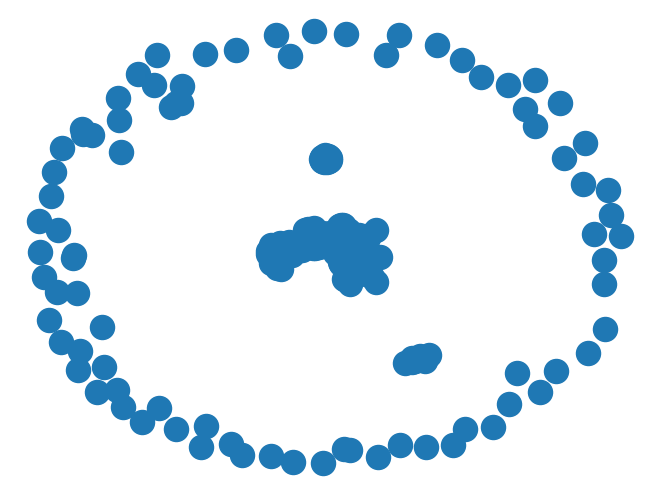

In [75]:
# Set layout of nodes
pos = nx.spring_layout(G)
nx.draw(G)

### Plot with Plotly

https://plotly.com/python/network-graphs/

In [76]:
# Set layout of nodes
pos = nx.spring_layout(G)
# pos=nx.kamada_kawai_layout(G)

# pos
# list(pos.items())[:3]

# Assign positions to nodes
for node in G.nodes:
    G.nodes[node]['pos'] = pos.get(node)

# G.nodes['Michal Kapral']

In [103]:
## List of nationalities for use in the node text

nationalities = [data[data['Joggler'] ==j]['Nationality'].unique()[0]  for j in jogglers]
nationalities = list(map(lambda x: x.replace('0', '?'), nationalities))

In [101]:
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='Greens',
        reversescale=False,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))


nationalities = [data[data['Joggler'] ==j]['Nationality'].unique()[0]  for j in jogglers]
nationalities = list(map(lambda x: x.replace('0', '?'), nationalities))

node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append(f'{jogglers[node]} ({nationalities[node]}): # of connections: '+str(len(adjacencies[1])))

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

In [102]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Joggling Community: Who has joggled with who?',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)),
                )

fig.update_layout( autosize=False, width=800, height=500, )

fig.show()

Would like to add the jogglers country too in the hover text.

Extension: Find each Joggler's 'Giduz' Number.

Bill Giduz has Giduz Number = 0

Anyone who has joggled with Giduz has a Giduz Number = 1

Anyone else who has joggled with someone with Giduz Number of 1, has Giduz Number = 2.Number
etc.

Anyone who can't trace to Giduz has a Giduz Number of infinity.

## All-Time Lists

In [51]:
def all_time_list(distance):
    fastest_times = data[data['Distance']==distance][['Joggler','Finish Time']].groupby(['Joggler']).min().reset_index()
    fastest_times = fastest_times.merge(data,how='left',left_on=['Joggler','Finish Time'],right_on=['Joggler','Finish Time'])
    fastest_times['Ranking'] = pd.to_numeric(fastest_times['Finish Time'].rank(method="min")).astype(int)
    fastest_times['Nationality'] = fastest_times['Nationality'].replace({'0':'Unknown'})
    fastest_times = fastest_times[['Ranking','Joggler','Gender','Nationality','Date','Event / Venue','Finish Time']].sort_values('Ranking').reset_index(drop=True)
    return fastest_times

all_time_list('5b Mile')

,Ranking,Joggler,Gender,Nationality,Date,Event / Venue,Finish Time
0,1,Matthew Feldman,M,USA,27/07/2012,Time Trial,00:06:33
1,2,Billy Gillen,M,USA,1989,Time Trial,00:07:41
2,3,Ben Schoenberg,M,Unknown,1996,"IJA, Rapid City",00:10:36
3,4,Barry Goldmeier,M,USA,1996,"IJA, Rapid City",00:10:37
4,5,Scott Jenkins,M,GBR,16/04/2020,Time Trial,00:15:21
